# Map one set of Pauli errors to another.

Requires numpy, matplotlib, qiskit, mitiq, qutip, and the PauliPER module.

In [1]:
#Helper libraries
from typing import List
import numpy as np
import numpy.typing as npt

#make numpy matrices easier to read
np.set_printoptions(precision=3, linewidth=125, suppress=True)

# Qiskit
import qiskit
from qiskit.quantum_info import SuperOp
from qiskit import QuantumCircuit

from qutip import *
from qutip.qip.operations import hadamard_transform, cnot, rz

# Has to come after QuTiP or the QuTiP functions of the same name get priority
from mitiq.pec.channels import kraus_to_super

import matplotlib.ticker as tck
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from PauliPER.ns_utils_ import (_Trotter, find_optimal_representation_super,
                       z_Trotter_new, mk_circ)
from PauliPER.PauliNoise import PauliNoise, model_coeffs, mk_omega
from PauliPER.PauliExperiment import PauliExperiment, get_gates

Looking at the dynamical evolution of the transverse field Ising model:

\begin{equation}
H = J_z \sum_{i} \sigma^{z}_{i} \sigma^{z}_{i+1} + h_x \sum_{i} \sigma^x_{i}
\end{equation}

We want to have Pauli noise, and then modulate the noise to a different Pauli noise. Can start from a model with random Pauli noise in the form:

\begin{equation}
\Lambda = \prod_{k \in \mathcal{K}} w_k (I \otimes I) + (1 - w_k) (P_k \otimes P_k^T)
\end{equation}

where $w_k = (1/2)(1 - e^{-2\lambda_k})$, and then modulate it to Pauli noise modeled by a different set of constants $w'_k = (1/2)(1 - e^{-2\phi_k})$. The inverse map connecting the two models is:

\begin{equation}
\Lambda^{-1} = \gamma \prod_{k \in \mathcal{K}} \omega_k (I \otimes I) - (1 - \omega_k) (P_k \otimes P_k^T),
\end{equation}

where $\gamma = e^{\sum_{k | \lambda_k > \phi_k} 2(\lambda_k - \phi_k)}$ and

\begin{equation}
\omega_k = \begin{cases}(1/2)(1 - e^{-2(\lambda_k - \phi_k)}),&\text{ if }\lambda_k \geq \phi_k \\ 1~&\text{     else}\end{cases}\, .
\end{equation}

# Make error model

In [46]:
''' This is the order the operators are always in. '''

# Note that this locks in the number of qubits to 2. I haven't expanded the code
# to go to more qubits yet.

labels = ['XI', 'YI', 'ZI', 'IX', 'IY', 'IZ', 'XX', 'XY', 'XZ', 'YX', 'YY', 
          'YZ', 'ZX', 'ZY', 'ZZ']

In [2]:
'''
zz in model_coeffs sets it to generate a target error model that retains 
only IZ, ZI, and ZZ errors. The mapping should cancel everything else.
'''

# Seeds used: 132, 154, and 193
model_coeffs_lambda, model_coeffs_phi = model_coeffs(rnd_seed=132, zz=True, m=4)
print(f'Random deviations from a baseline: {model_coeffs_lambda}.\n')
print(f'Select model to approximate output: {model_coeffs_phi}.\n')

Random deviations from a baseline: [0.00124, 0.00076, 0.00175, 0.00151, 0.00139, 0.00088, 0.00059, 0.00059, 0.00051, 0.00043000000000000004, 0.00049, 0.00028, 0.00045, 0.00041, 0.0006000000000000001].

Select model to approximate output: [0, 0, 0.0004375, 0, 0, 0.00022, 0, 0, 0, 0, 0, 0, 0, 0, 0.00015000000000000001].



In [5]:
''' Instantiate a PauliNoise class with the model coefficients and the labels. '''
p_noise = PauliNoise(model_coeffs_lambda, labels)

In [6]:
''' Instantiate the target noise model coefficients. '''
p_noise.instantiate_target(model_coeffs_phi)

In [7]:
''' Create the inverse mapping. '''
p_noise.define_inverse()

In [8]:
''' One can print the associated probabilities if one wishes. '''
p_noise.inverse_omegas

[0.998761536329705,
 0.9992405773074605,
 0.9986892211499144,
 0.9984922778064312,
 0.998611930310831,
 0.9993404354083992,
 0.9994103479631211,
 0.9994103479631211,
 0.9994902600115885,
 0.9995701848470067,
 0.9995102400215865,
 0.9997200783853674,
 0.9995502024392637,
 0.9995901680540621,
 0.9995502024392637]

In [9]:
''' These are the three overheads: for rx, rz, and cx respectively. '''
p_noise.gammas

(1.0066469938554377, 1.0071454074645874, 1.0223920205660437)

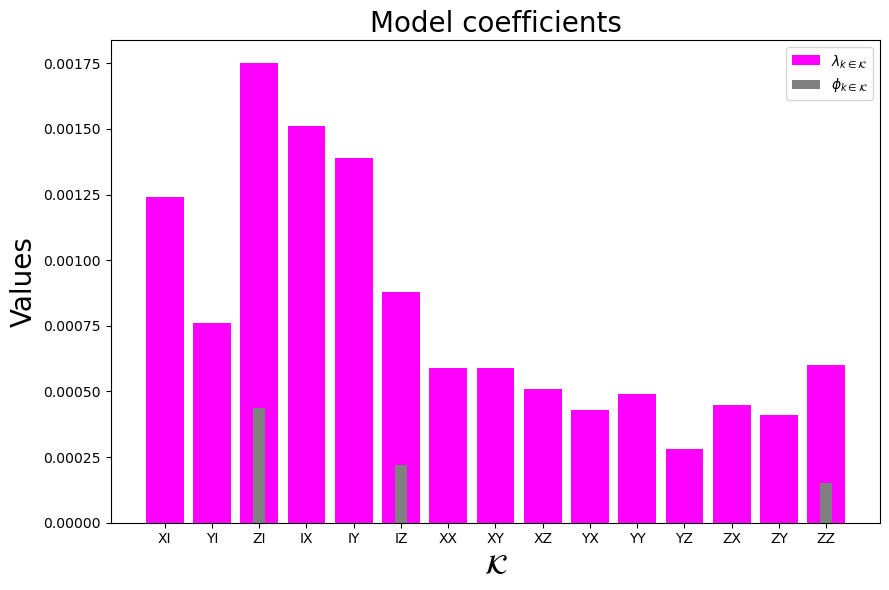

In [10]:
''' This displays the model coefficient bar graph. Can also title and save it to pdf. '''
p_noise.make_plot(ttl='Model coefficients', save_file=None)

## Now instantiate the error reduction algorithm.

In [11]:
'''
Generates a PauliExperiment class. Give it the PauliNoise model crated above,
the Trotter step size, the Jz coupling in the Hamiltonian, and the rx coupling.
'''
p_experiment = PauliExperiment(p_noise, 0.2, 1, 1)

In [12]:
''' This runs a simulation. Give it the repetitions and the number of Trotter steps. '''
trotter_steps = 5
p_experiment.run_experiment(1500, trotter_steps)

In [13]:
''' Define the initial state. Here, I've set it to the all |+> state. '''
psi0x = tensor(hadamard_transform() * basis(2,0), hadamard_transform() * basis(2,0))
den0x = ket2dm(psi0x)
den0x_vec = operator_to_vector(den0x) # QuTiP uses the column stacking convention, like mitiq.

In [15]:
'''
The processed density matrices are saved individually, and then 
create_final_dm makes and saves the final density matrix after averaging.
'''
p_experiment.process_density_matrices(den0x_vec)
p_experiment.create_final_dm()

In [16]:
p_experiment.final_dm

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.425+0.j    0.166-0.054j 0.166-0.053j 0.416+0.j   ]
 [0.166+0.054j 0.076+0.j    0.066+0.j    0.166+0.053j]
 [0.166+0.053j 0.066+0.j    0.076+0.j    0.166+0.054j]
 [0.416+0.j    0.166-0.053j 0.166-0.054j 0.425+0.j   ]]

In [31]:
''' Can also perform the exact evolution for each error model within this class. '''
targ_wo_mit = p_experiment.evolve_target_without_mitigation(den0x_vec.copy(), trotter_steps)
targ_wo_mit

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.425+0.j    0.166-0.054j 0.165-0.054j 0.419+0.j   ]
 [0.166+0.054j 0.075+0.j    0.071+0.j    0.165+0.054j]
 [0.165+0.054j 0.071+0.j    0.075+0.j    0.166+0.054j]
 [0.419+0.j    0.165-0.054j 0.166-0.054j 0.425+0.j   ]]

In [32]:
init_wo_mit = p_experiment.evolve_initial_without_mitigation(den0x_vec.copy(), trotter_steps)
init_wo_mit

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.399+0.j    0.143-0.045j 0.149-0.048j 0.353+0.j   ]
 [0.143+0.045j 0.101+0.j    0.06 +0.j    0.149+0.048j]
 [0.149+0.048j 0.06 +0.j    0.101+0.j    0.143+0.045j]
 [0.353+0.j    0.149-0.048j 0.143-0.045j 0.399+0.j   ]]

Matrix distance: $\sqrt{\text{Tr}((A-B)(A-B)^\dagger)}$

In [33]:
''' Check the matrix distances of the density matrices. '''

rho_diff_ini = (init_wo_mit - targ_wo_mit)

print(f'Before mitigation: {np.sqrt((rho_diff_ini * rho_diff_ini.dag()).tr())}')

rho_diff_fin = (p_experiment.final_dm - targ_wo_mit)

print(f'After mitigation: {np.sqrt((rho_diff_fin * rho_diff_fin.dag()).tr())}')

Before mitigation: 0.12295527507684607
After mitigation: 0.009198053022623706


In [24]:
print(p_noise.model_gates == pauli_gates_dict)
print(p_noise.expanded_gates == pgd_big)

True
True


## Processing data for bar graphs.

In [34]:
comb_list_lambda = [(a, b) for a, b in zip(p_noise.lam_omegas, labels)]
comb_list_phi = [(a, b) for a, b in zip(p_noise.target_omegas, labels)]

In [35]:
outcome_lam = [(x, np.real((init_wo_mit * p_noise.model_gates[x]).tr())) for x in labels]
outcome_lam.insert(0, ('II', 1.0))

outcome_phi = [(x, np.real((targ_wo_mit * p_noise.model_gates[x]).tr())) for x in labels]
outcome_phi.insert(0, ('II', 1.0))

outcome_app = [(x, np.real((p_experiment.final_dm * 
                            p_noise.model_gates[x]).tr())) for x in labels]
outcome_app.insert(0, ('II', 1.0))

In [38]:
''' Make dictionaries of the expectation value outcomes. '''

outcome_lam_dict = {a: b for a, b in outcome_lam}
outcome_phi_dict = {a: b for a, b in outcome_phi}
outcome_app_dict = {a: b for a, b in outcome_app}

In [39]:
types = ['I', 'X', 'Y', 'Z']
x_lam = [1, 2, 3, 4]
y_lam = [1, 2, 3, 4]
z_lam = [outcome_lam_dict[a+b] for a in types for b in types]
z_phi = [outcome_phi_dict[a+b] for a in types for b in types]
z_app = [outcome_app_dict[a+b] for a in types for b in types]

In [40]:
''' Organize the data properly for plotting. '''
z_lam = np.zeros((4,4))
z_phi = np.zeros((4,4))
z_app = np.zeros((4,4))
for n,a in enumerate(['I', 'X', 'Y', 'Z'][::-1]):
    for m,b in enumerate(['I', 'X', 'Y', 'Z']):
        z_lam[n,m] = outcome_lam_dict[a+b]
        z_phi[n,m] = outcome_phi_dict[a+b]
        z_app[n,m] = outcome_app_dict[a+b]

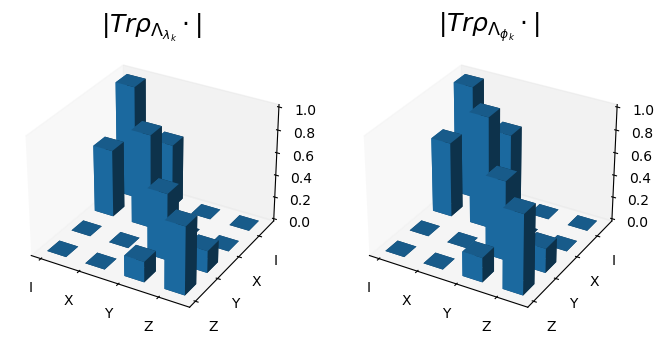

In [43]:
# set up the figure and axes
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.grid(False)
ax2.grid(False)

_x = [0, 1, 2, 3]
_y = [0, 1, 2, 3]
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

topl = np.abs(z_lam).flatten()
topp = np.abs(z_phi).flatten()
bottoml = np.zeros_like(topl)
bottomp = np.zeros_like(topp)
width = depth = 0.5

ax1.bar3d(x, y, bottoml, width, depth, topl, shade=True)
ax1.set_title(r'$|Tr\rho_{\Lambda_{\lambda_k}}\cdot|$', fontsize=18)
majors = [0, 1, 2, 3]
ax1.xaxis.set_major_locator(tck.FixedLocator(majors))
ax1.yaxis.set_major_locator(tck.FixedLocator(majors))
ax1.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax1.set_yticklabels(('I', 'X', 'Y', 'Z')[::-1])

ax2.bar3d(x, y, bottomp, width, depth, topp, shade=True)
ax2.set_title(r'$|Tr\rho_{\Lambda_{\phi_k}}\cdot|$', fontsize=18)
ax2.xaxis.set_major_locator(tck.FixedLocator(majors))
ax2.yaxis.set_major_locator(tck.FixedLocator(majors))
ax2.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax2.set_yticklabels(('I', 'X', 'Y', 'Z')[::-1])

plt.show()

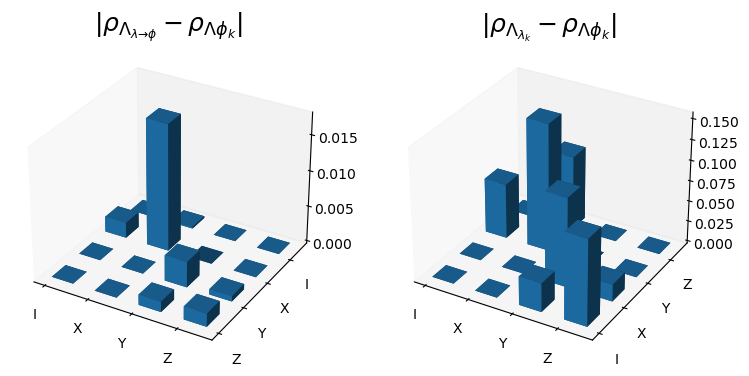

In [44]:
# set up the figure and axes
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.grid(False)
ax2.grid(False)

_x = [0, 1, 2, 3]
_y = [0, 1, 2, 3]
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

topl = np.abs(z_app - z_phi).flatten()
topp = np.abs(z_lam - z_phi).flatten()
bottoml = np.zeros_like(topl)
# bottomp = np.zeros_like(topp)
width = depth = 0.5

ax1.bar3d(x, y, bottoml, width, depth, topl, shade=True)
ax1.set_title(r'|$\rho_{\Lambda_{\lambda\to\phi}} - \rho_{\Lambda{\phi_k}}$|',
             fontsize=18)
majors = [0, 1, 2, 3]
ax1.xaxis.set_major_locator(tck.FixedLocator(majors))
ax1.yaxis.set_major_locator(tck.FixedLocator(majors))
ax1.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax1.set_yticklabels(('I', 'X', 'Y', 'Z')[::-1])

ax2.bar3d(x, y, bottomp, width, depth, topp, shade=True)
ax2.set_title(r'|$\rho_{\Lambda_{\lambda_k}} - \rho_{\Lambda{\phi_k}}$|',
             fontsize=18)
ax2.xaxis.set_major_locator(tck.FixedLocator(majors))
ax2.yaxis.set_major_locator(tck.FixedLocator(majors))
ax2.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax2.set_yticklabels(('I', 'X', 'Y', 'Z'))

plt.show()